In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


## Importing the Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

## Importing the Dataset

In [41]:
df_train =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 2_000_000)
df_train.head()

[Voting] ....................... (1 of 3) Processing lr, total=   0.8s
[Voting] ...................... (3 of 3) Processing svr, total=   4.0s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [42]:
df_train = df_train.iloc[:,1:]

## Exploratory Data Analysis

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float64
 1   pickup_datetime    object 
 2   pickup_longitude   float64
 3   pickup_latitude    float64
 4   dropoff_longitude  float64
 5   dropoff_latitude   float64
 6   passenger_count    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 106.8+ MB


In [44]:
df_train.shape

(2000000, 7)

In [45]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


In [46]:
df_train.isna().sum()

[Voting] ....................... (2 of 3) Processing rf, total=   5.5s


fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

In [47]:
df_train = df_train.dropna()

In [48]:
df_train = df_train[(df_train['fare_amount'] > 1) & (df_train['fare_amount'] < 100)]

In [49]:
df_train = df_train[(df_train['passenger_count'] >= 1) & (df_train['passenger_count'] <= 6)]

In [50]:
df_train = df_train[
    (df_train['pickup_longitude'] > -75) & (df_train['pickup_longitude'] < -72) &
    (df_train['dropoff_longitude'] > -75) & (df_train['dropoff_longitude'] < -72) &
    (df_train['pickup_latitude'] > 40) & (df_train['pickup_latitude'] < 42) &
    (df_train['dropoff_latitude'] > 40) & (df_train['dropoff_latitude'] < 42)
]

In [51]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # kilometers

In [52]:
df_train['distance_km'] = haversine(
    df_train['pickup_latitude'], df_train['pickup_longitude'],
    df_train['dropoff_latitude'], df_train['dropoff_longitude']
)

df_train = df_train[(df_train['distance_km'] > 0.1) & (df_train['distance_km'] < 30)]

<Axes: >

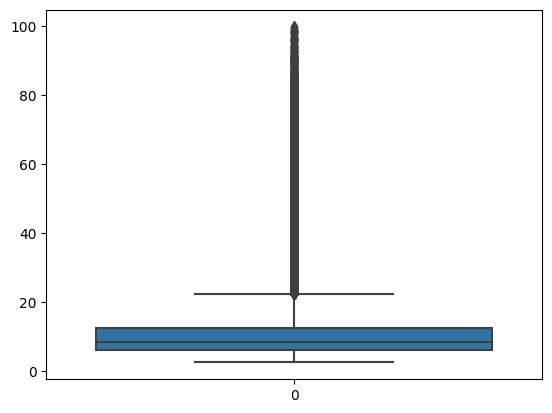

In [53]:
sns.boxplot(df_train['fare_amount'])

<Axes: xlabel='fare_amount', ylabel='Density'>

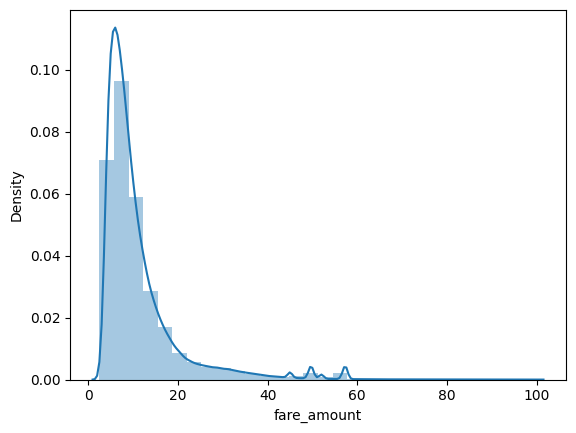

In [54]:
sns.distplot(df_train['fare_amount'], kde=True, bins=30)

In [55]:
X= df_train.iloc[:,1:]
y = df_train.iloc[:,0]

In [56]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,max_depth =10 ,random_state=2,bootstrap=True, max_samples=5000,n_jobs=1)
#rf.fit(X.iloc[:,1:],y)
#cv = cross_val_score(rf, X.iloc[:,1:],y,cv=10)

In [57]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
#br.fit(X.iloc[:,1:],y)


In [58]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
sr = SVR(kernel = 'rbf')
br = BaggingRegressor(n_estimators = 10, estimator=sr, max_samples=5000, bootstrap=True )
#br.fit(X.iloc[:,1:],y)

In [59]:
from sklearn.ensemble import VotingRegressor
vr = VotingRegressor([('lr', lr), ('rf', rf),('svr',br)], verbose=True, n_jobs=-1)
vr.fit(X.iloc[:,1:],y)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(max_depth=10,
                                                   max_samples=5000, n_jobs=1,
                                                   random_state=2)),
                            ('svr',
                             BaggingRegressor(estimator=SVR(),
                                              max_samples=5000))],
                n_jobs=-1, verbose=True)

In [60]:
df_test = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv',parse_dates=["pickup_datetime"])
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [61]:
key = df_test['key']
df_test = df_test.iloc[:,2:]

In [62]:
df_test['distance_km'] = haversine(
    df_test['pickup_latitude'], df_test['pickup_longitude'],
    df_test['dropoff_latitude'], df_test['dropoff_longitude']
)

In [63]:
y_pred = vr.predict(df_test)

In [64]:
results = pd.DataFrame({'key':key,'fare_amount':y_pred})
print(results)

                              key  fare_amount
0     2015-01-27 13:08:24.0000002     8.818335
1     2015-01-27 13:08:24.0000003     8.804209
2     2011-10-08 11:53:44.0000002     5.414243
3     2012-12-01 21:12:12.0000002     8.162742
4     2012-12-01 21:12:12.0000003    14.570680
...                           ...          ...
9909  2015-05-10 12:37:51.0000002     8.238091
9910  2015-01-12 17:05:51.0000001    10.714904
9911  2015-04-19 20:44:15.0000001    41.872774
9912  2015-01-31 01:05:19.0000005    19.199239
9913  2015-01-18 14:06:23.0000006     6.730667

[9914 rows x 2 columns]


In [65]:
results.to_csv('submission.csv', index=False)